In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

C:\Users\ashut\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ashut\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('train_modified.csv')

In [3]:
train.head()

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,37,1,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,30,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,34,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,28,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,31,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
train.shape

(87020, 51)

In [5]:
target='Disbursed'
IDcol = 'ID'

In [6]:
train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

In [22]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        #xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.891681


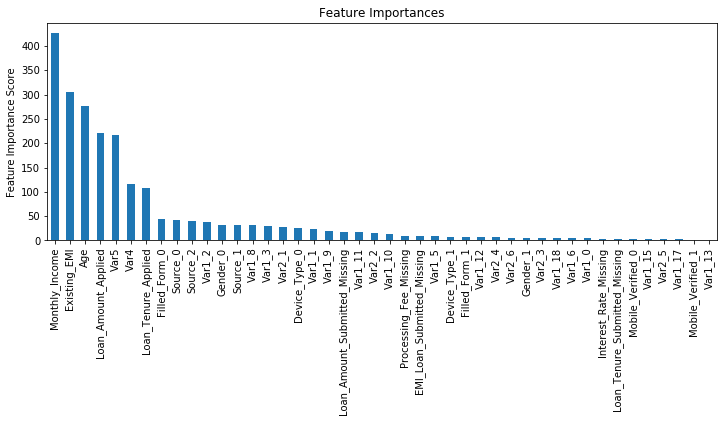

In [23]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, predictors)

In [25]:
param_test1 = {
 'n_estimators':np.arange(60,200,10)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83330, std: 0.00931, params: {'n_estimators': 60},
  mean: 0.83606, std: 0.00949, params: {'n_estimators': 70},
  mean: 0.83758, std: 0.00988, params: {'n_estimators': 80},
  mean: 0.83877, std: 0.00932, params: {'n_estimators': 90},
  mean: 0.83960, std: 0.00804, params: {'n_estimators': 100},
  mean: 0.84003, std: 0.00792, params: {'n_estimators': 110},
  mean: 0.84097, std: 0.00656, params: {'n_estimators': 120},
  mean: 0.84056, std: 0.00700, params: {'n_estimators': 130},
  mean: 0.84016, std: 0.00680, params: {'n_estimators': 140},
  mean: 0.84086, std: 0.00662, params: {'n_estimators': 150},
  mean: 0.84047, std: 0.00628, params: {'n_estimators': 160},
  mean: 0.83991, std: 0.00642, params: {'n_estimators': 170},
  mean: 0.83931, std: 0.00655, params: {'n_estimators': 180},
  mean: 0.83830, std: 0.00707, params: {'n_estimators': 190}],
 {'n_estimators': 120},
 0.8409693870888774)

In [27]:
param_test1 = {
 'max_depth':np.arange(3,10,2),
 'min_child_weight':np.arange(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83668, std: 0.00877, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83684, std: 0.00910, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83662, std: 0.00807, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84097, std: 0.00656, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84050, std: 0.00595, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84001, std: 0.00521, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83842, std: 0.00638, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83684, std: 0.00631, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83606, std: 0.00569, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.83240, std: 0.00668, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.83198, std: 0.00603, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83434, std: 0.00679, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

In [29]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[0,1,2]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.84016, std: 0.00823, params: {'max_depth': 4, 'min_child_weight': 0},
  mean: 0.84033, std: 0.00666, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.84047, std: 0.00717, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.84058, std: 0.00530, params: {'max_depth': 5, 'min_child_weight': 0},
  mean: 0.84097, std: 0.00656, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84069, std: 0.00536, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.84022, std: 0.00530, params: {'max_depth': 6, 'min_child_weight': 0},
  mean: 0.84025, std: 0.00535, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.84088, std: 0.00572, params: {'max_depth': 6, 'min_child_weight': 2}],
 {'max_depth': 5, 'min_child_weight': 1},
 0.8409693870888774)

In [34]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, max_depth=5, min_child_weight=1, n_estimators=120, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84097, std: 0.00656, params: {'gamma': 0.0},
  mean: 0.84033, std: 0.00654, params: {'gamma': 0.1},
  mean: 0.84203, std: 0.00469, params: {'gamma': 0.2},
  mean: 0.84113, std: 0.00674, params: {'gamma': 0.3},
  mean: 0.84059, std: 0.00582, params: {'gamma': 0.4}],
 {'gamma': 0.2},
 0.8420250927545139)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.896065


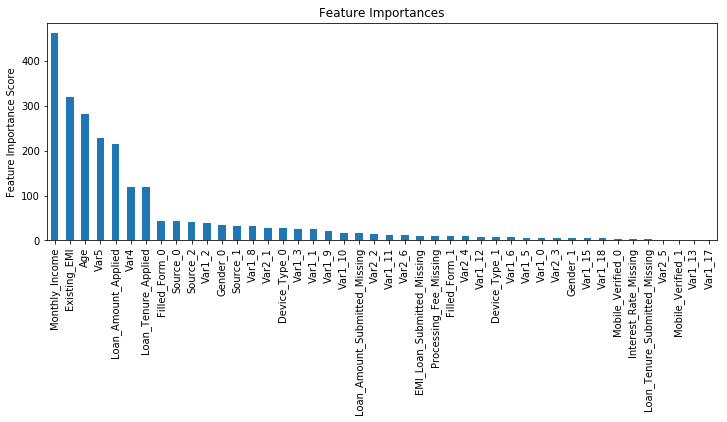

In [33]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=120,
 max_depth=5,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

In [35]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, max_depth=5, min_child_weight=1, n_estimators=120, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83903, std: 0.00716, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.83933, std: 0.00712, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.83703, std: 0.00644, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.84010, std: 0.00708, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.83953, std: 0.00739, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.84138, std: 0.00635, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.83928, std: 0.00712, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.84064, std: 0.00690, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.83883, std: 0.00771, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.83966, std: 0.00813, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.84203, std: 0.00469, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.84203, std: 0.00666, params: {'colsample_bytree': 0.8, 'subsample'

In [38]:
param_test4a = {
 'subsample':[i/100.0 for i in range(75,85,2)],
 'colsample_bytree':[i/100.0 for i in range(85,95,2)]
}
gsearch4a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, max_depth=5, min_child_weight=1, n_estimators=120, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4a, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4a.fit(train[predictors],train[target])
gsearch4a.grid_scores_, gsearch4a.best_params_, gsearch4a.best_score_

([mean: 0.83931, std: 0.00642, params: {'colsample_bytree': 0.85, 'subsample': 0.75},
  mean: 0.84009, std: 0.00683, params: {'colsample_bytree': 0.85, 'subsample': 0.77},
  mean: 0.84091, std: 0.00604, params: {'colsample_bytree': 0.85, 'subsample': 0.79},
  mean: 0.84199, std: 0.00578, params: {'colsample_bytree': 0.85, 'subsample': 0.81},
  mean: 0.84105, std: 0.00522, params: {'colsample_bytree': 0.85, 'subsample': 0.83},
  mean: 0.83886, std: 0.00713, params: {'colsample_bytree': 0.87, 'subsample': 0.75},
  mean: 0.84140, std: 0.00592, params: {'colsample_bytree': 0.87, 'subsample': 0.77},
  mean: 0.84058, std: 0.00713, params: {'colsample_bytree': 0.87, 'subsample': 0.79},
  mean: 0.84147, std: 0.00593, params: {'colsample_bytree': 0.87, 'subsample': 0.81},
  mean: 0.84053, std: 0.00676, params: {'colsample_bytree': 0.87, 'subsample': 0.83},
  mean: 0.83968, std: 0.00665, params: {'colsample_bytree': 0.89, 'subsample': 0.75},
  mean: 0.84060, std: 0.00748, params: {'colsample_byt

In [40]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, subsample=0.81, colsample_bytree=0.93, max_depth=5, min_child_weight=1, n_estimators=120, gamma=0.2,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.84258, std: 0.00801, params: {'reg_alpha': 1e-05},
  mean: 0.84251, std: 0.00716, params: {'reg_alpha': 0.01},
  mean: 0.84257, std: 0.00717, params: {'reg_alpha': 0.1},
  mean: 0.84295, std: 0.00618, params: {'reg_alpha': 1},
  mean: 0.81195, std: 0.01620, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 0.8429452351850495)

In [42]:
param_test5a = {
 'reg_alpha':np.arange(0.8,1.3,0.05)
}
gsearch5a = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, subsample=0.81, colsample_bytree=0.93, max_depth=5, min_child_weight=1, n_estimators=120, gamma=0.2,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5a, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5a.fit(train[predictors],train[target])
gsearch5a.grid_scores_, gsearch5a.best_params_, gsearch5a.best_score_

([mean: 0.84227, std: 0.00686, params: {'reg_alpha': 0.80000000000000004},
  mean: 0.84212, std: 0.00594, params: {'reg_alpha': 0.85000000000000009},
  mean: 0.84271, std: 0.00646, params: {'reg_alpha': 0.90000000000000013},
  mean: 0.84259, std: 0.00711, params: {'reg_alpha': 0.95000000000000018},
  mean: 0.84295, std: 0.00618, params: {'reg_alpha': 1.0000000000000002},
  mean: 0.84190, std: 0.00695, params: {'reg_alpha': 1.0500000000000003},
  mean: 0.84290, std: 0.00741, params: {'reg_alpha': 1.1000000000000003},
  mean: 0.84244, std: 0.00685, params: {'reg_alpha': 1.1500000000000004},
  mean: 0.84322, std: 0.00781, params: {'reg_alpha': 1.2000000000000004},
  mean: 0.84238, std: 0.00564, params: {'reg_alpha': 1.2500000000000004}],
 {'reg_alpha': 1.2000000000000004},
 0.8432244014275202)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.891469


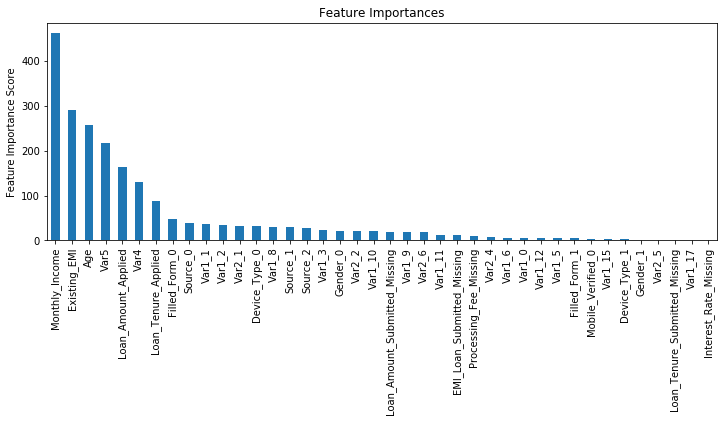

In [43]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=120,
 max_depth=5,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.81,
 colsample_bytree=0.93,
 reg_alpha=1.2,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.892664


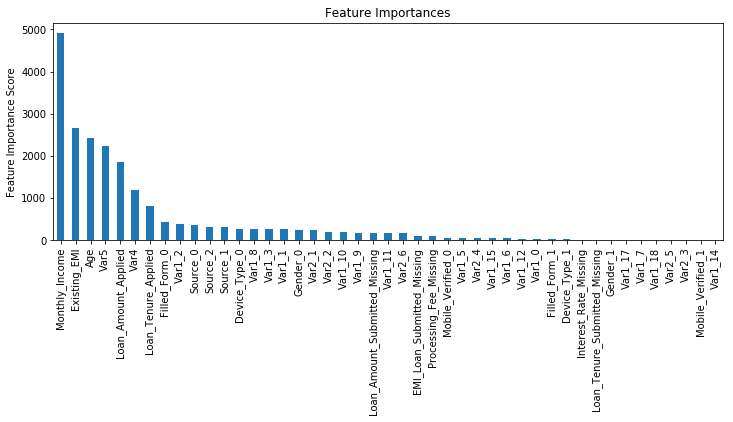

In [44]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1200,
 max_depth=5,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.81,
 colsample_bytree=0.93,
 reg_alpha=1.2,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.909074


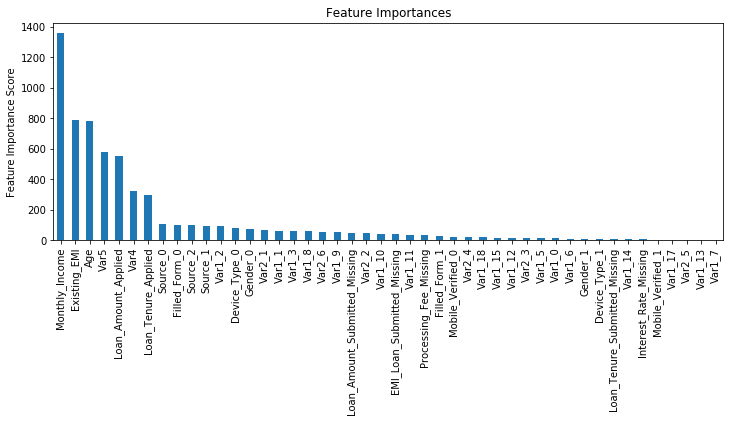

In [46]:
xgb5 = XGBClassifier(
 learning_rate =0.05,
 n_estimators=600,
 max_depth=5,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb5, train, predictors)